## Import Packages and Dataset

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score 


import warnings
warnings.filterwarnings('ignore')

In [206]:
data = pd.read_excel('data-uas.xlsx', sheet_name="Data")
data.head()

,branch,cutoff_date,area,region,first_date_disbursement,active_borrowers,active_agent,deliquency_rate,outstanding,weekly_disbursement,weekly_new_borrower_per_bp
0,POINTID_42,2018-10-20,AREAID_27,REGION_JR1,2017-09-09,1108,5,1%-2.5%,2150,20,3.0
1,POINTID_35,2018-10-20,AREAID_1,REGION_JH,2017-07-29,1515,7,5%-10%,2500,110,1.0
2,POINTID_24,2018-10-20,AREAID_20,REGION_JH,2017-06-10,1092,5,2.5%-5%,1850,75,7.0
3,POINTID_62,2018-10-20,AREAID_13,REGION_JR2,2018-05-05,683,3,0%,1600,145,17.0
4,POINTID_45,2018-10-20,AREAID_21,REGION_JR1,2017-09-16,2294,8,0%-1%,4300,50,7.0


## Data Analysis

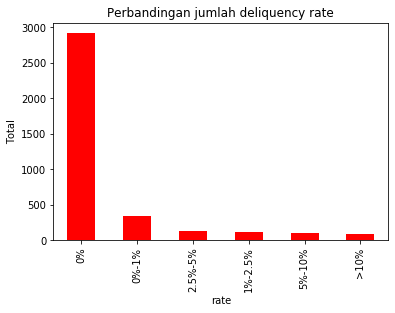

In [207]:
data['deliquency_rate'].value_counts().plot(kind='bar', color="r")
plt.title("Perbandingan jumlah deliquency rate")
plt.xlabel('rate')
plt.ylabel('Total')
plt.show()

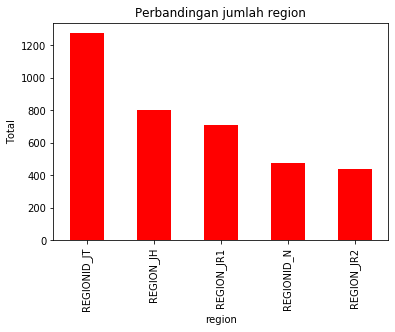

In [208]:
data['region'].value_counts().plot(kind='bar', color="r")
plt.title("Perbandingan jumlah region")
plt.xlabel('region')
plt.ylabel('Total')
plt.show()

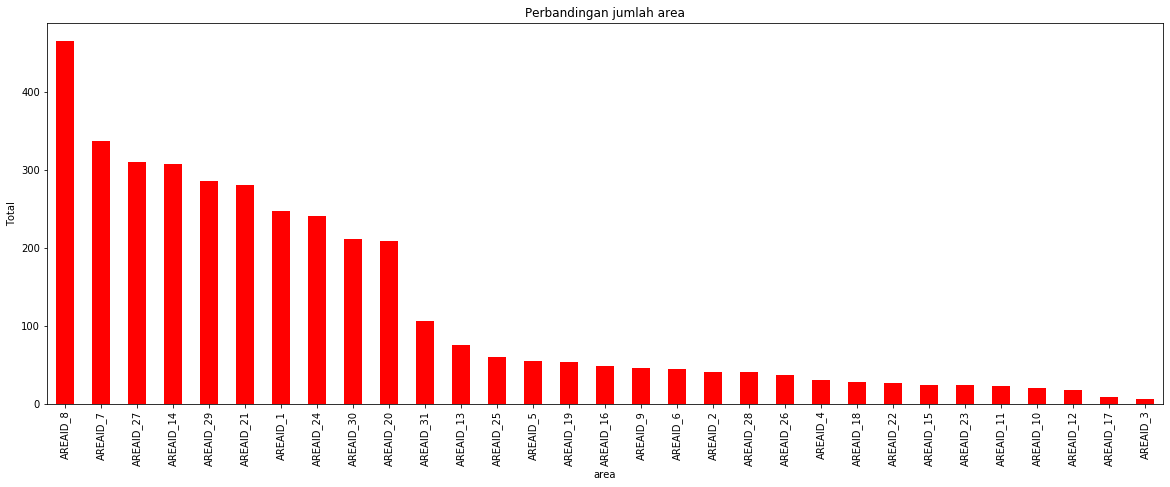

In [209]:
plt.figure(figsize=(20,7))
data['area'].value_counts().plot(kind='bar', color="r")
plt.title("Perbandingan jumlah area")
plt.xlabel('area')
plt.ylabel('Total')
plt.show()

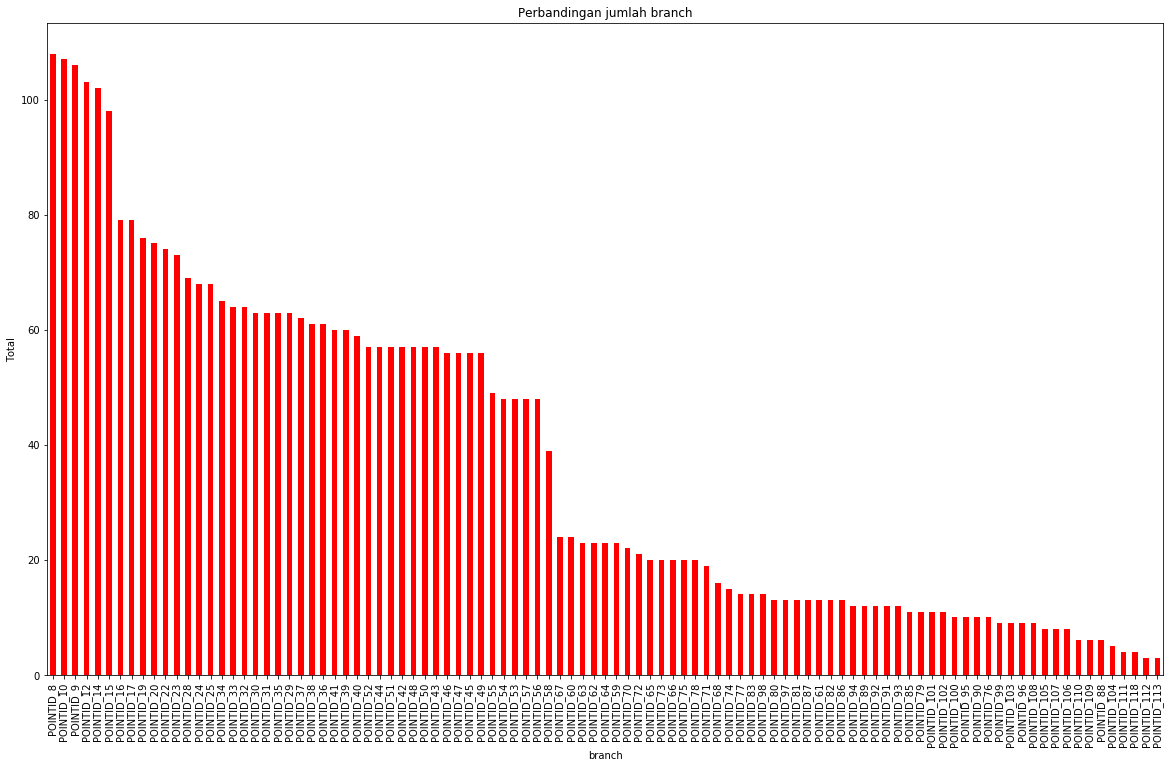

In [210]:
plt.figure(figsize=(20,12))
data['branch'].value_counts().plot(kind='bar', color="r")
plt.title("Perbandingan jumlah branch")
plt.xlabel('branch')
plt.ylabel('Total')
plt.show()

## Preprocessing

**Missing Values Handling**

In [211]:
pd.isnull(data).sum()

branch                          0
cutoff_date                     0
area                            0
region                          0
first_date_disbursement         0
active_borrowers                0
active_agent                    0
deliquency_rate                 0
outstanding                     0
weekly_disbursement             0
weekly_new_borrower_per_bp    163
dtype: int64

In [212]:
data = data.fillna({
    'weekly_new_borrower_per_bp' : data['weekly_new_borrower_per_bp'].median()
})
pd.isnull(data).sum()

branch                        0
cutoff_date                   0
area                          0
region                        0
first_date_disbursement       0
active_borrowers              0
active_agent                  0
deliquency_rate               0
outstanding                   0
weekly_disbursement           0
weekly_new_borrower_per_bp    0
dtype: int64

**Feature Engineering**

In [213]:
branch = data['branch'].value_counts()

In [214]:
data_1 = pd.DataFrame({'branch' : branch.index})
data_1.head()

,branch
0,POINTID_8
1,POINTID_10
2,POINTID_9
3,POINTID_12
4,POINTID_14


In [215]:
data_1['total_weeks'] = branch.values
data_1

,branch,total_weeks
0,POINTID_8,108
1,POINTID_10,107
2,POINTID_9,106
3,POINTID_12,103
4,POINTID_14,102
5,POINTID_15,98
6,POINTID_16,79
7,POINTID_17,79
8,POINTID_19,76
9,POINTID_20,75


In [216]:
data_1 = pd.DataFrame(data.groupby(['branch'])['branch'].size())
data_1.columns = ['Total weeks']
data_1.head()

,Total weeks
branch,
POINTID_10,107
POINTID_100,10
POINTID_101,11
POINTID_102,11
POINTID_103,9


In [217]:
data_2 = pd.DataFrame(data.groupby(['branch','deliquency_rate'])['deliquency_rate'].size())
data_2.columns = ['total_rate']
data_2.head(6)

total_rate
branch     deliquency_rate            
POINTID_10 0%                       30
           0%-1%                    50
           1%-2.5%                   2
           2.5%-5%                   1
           5%-10%                    7
           >10%                     17

In [218]:
data_2 = data_2.reset_index()
data_2.head(6)

,branch,deliquency_rate,total_rate
0,POINTID_10,0%,30
1,POINTID_10,0%-1%,50
2,POINTID_10,1%-2.5%,2
3,POINTID_10,2.5%-5%,1
4,POINTID_10,5%-10%,7
5,POINTID_10,>10%,17


In [219]:
data_2['dr_0%'] = np.where(data_2['deliquency_rate'] == '0%', data_2['total_rate'], 0)
data_2['dr_0%-1%'] = np.where(data_2['deliquency_rate'] == '0%-1%', data_2['total_rate'], 0)
data_2['dr_1%-2.5%'] = np.where(data_2['deliquency_rate'] == '1%-2.5%', data_2['total_rate'], 0)
data_2['dr_2.5%-5%'] = np.where(data_2['deliquency_rate'] == '2.5%-5%', data_2['total_rate'], 0)
data_2['dr_5%-10%'] = np.where(data_2['deliquency_rate'] == '5%-10%', data_2['total_rate'], 0)
data_2['dr_>10%'] = np.where(data_2['deliquency_rate'] == '>10%', data_2['total_rate'], 0)

In [220]:
data_2.head()

,branch,deliquency_rate,total_rate,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%
0,POINTID_10,0%,30,30,0,0,0,0,0
1,POINTID_10,0%-1%,50,0,50,0,0,0,0
2,POINTID_10,1%-2.5%,2,0,0,2,0,0,0
3,POINTID_10,2.5%-5%,1,0,0,0,1,0,0
4,POINTID_10,5%-10%,7,0,0,0,0,7,0


In [221]:
data_2 = data_2.drop(['deliquency_rate','total_rate'],axis=1)

In [222]:
data_2 = data_2.groupby(['branch']).sum()
data_2.head()

,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%
branch,,,,,,
POINTID_10,30,50,2,1,7,17
POINTID_100,10,0,0,0,0,0
POINTID_101,11,0,0,0,0,0
POINTID_102,11,0,0,0,0,0
POINTID_103,9,0,0,0,0,0


In [223]:
data_3 = data.groupby(['branch'])['active_borrowers','active_agent','outstanding','weekly_disbursement','weekly_new_borrower_per_bp'].mean()
data_3.head()

,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp
branch,,,,,
POINTID_10,920.317757,6.383178,2005.607477,88.691589,6.028037
POINTID_100,173.400000,2.100000,535.000000,101.000000,14.200000
POINTID_101,251.000000,2.090909,695.454545,124.545455,20.000000
POINTID_102,140.636364,1.909091,368.181818,85.454545,14.636364
POINTID_103,128.111111,1.555556,333.333333,79.444444,20.000000


In [224]:
data_fix = data_1.join(data_2).join(data_3)
data_fix.head()

,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp
branch,,,,,,,,,,,,
POINTID_10,107,30,50,2,1,7,17,920.317757,6.383178,2005.607477,88.691589,6.028037
POINTID_100,10,10,0,0,0,0,0,173.400000,2.100000,535.000000,101.000000,14.200000
POINTID_101,11,11,0,0,0,0,0,251.000000,2.090909,695.454545,124.545455,20.000000
POINTID_102,11,11,0,0,0,0,0,140.636364,1.909091,368.181818,85.454545,14.636364
POINTID_103,9,9,0,0,0,0,0,128.111111,1.555556,333.333333,79.444444,20.000000


In [225]:
data_fix = data_fix.reset_index()
data_fix.head()

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp
0,POINTID_10,107,30,50,2,1,7,17,920.317757,6.383178,2005.607477,88.691589,6.028037
1,POINTID_100,10,10,0,0,0,0,0,173.400000,2.100000,535.000000,101.000000,14.200000
2,POINTID_101,11,11,0,0,0,0,0,251.000000,2.090909,695.454545,124.545455,20.000000
3,POINTID_102,11,11,0,0,0,0,0,140.636364,1.909091,368.181818,85.454545,14.636364
4,POINTID_103,9,9,0,0,0,0,0,128.111111,1.555556,333.333333,79.444444,20.000000


## Clustering K-Means

In [226]:
X = data_fix.drop(['branch'], axis=1)

**Elbow Method**

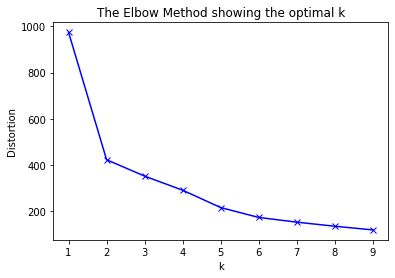

In [227]:
distortions = []
K = range (1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'),axis=1))/ X.shape[0])

# plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**K-Means**

In [228]:
model_kme = KMeans(n_clusters= 5)

In [229]:
model_kme.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [230]:
pred_kme = model_kme.predict(X)
pred_kme

array([1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 4, 3, 3, 4,
       4, 1, 1, 2, 2, 2, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1,
       4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0])

In [231]:
data_fix['cluster'] = pred_kme
data_fix.head()

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
0,POINTID_10,107,30,50,2,1,7,17,920.317757,6.383178,2005.607477,88.691589,6.028037,1
1,POINTID_100,10,10,0,0,0,0,0,173.400000,2.100000,535.000000,101.000000,14.200000,0
2,POINTID_101,11,11,0,0,0,0,0,251.000000,2.090909,695.454545,124.545455,20.000000,2
3,POINTID_102,11,11,0,0,0,0,0,140.636364,1.909091,368.181818,85.454545,14.636364,0
4,POINTID_103,9,9,0,0,0,0,0,128.111111,1.555556,333.333333,79.444444,20.000000,0


In [232]:
count_cluster = data_fix['cluster'].value_counts()
count_cluster

2    30
1    27
0    27
4    13
3     2
Name: cluster, dtype: int64

## Evaluation

In [233]:
silhouette_avg = silhouette_score(X, pred_kme)
silhouette_avg

0.5538525331738707

## Result

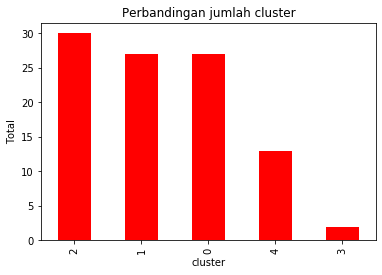

In [234]:
data_fix['cluster'].value_counts().plot(kind='bar', color="r")
plt.title("Perbandingan jumlah cluster")
plt.xlabel('cluster')
plt.ylabel('Total')
plt.show()

In [235]:
percentage = pd.DataFrame({
    'cluster' : count_cluster.index,
    'members' : count_cluster.values
})
percentage['percentage (%)'] = round((percentage['members']/sum(percentage['members']))*100,2)
percentage

,cluster,members,percentage (%)
0,2,30,30.30
1,1,27,27.27
2,0,27,27.27
3,4,13,13.13
4,3,2,2.02


- cluster 0

In [236]:
data_fix[data_fix['cluster'] == 0]

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
1,POINTID_100,10,10,0,0,0,0,0,173.400000,2.100000,535.000000,101.000000,14.200000,0
3,POINTID_102,11,11,0,0,0,0,0,140.636364,1.909091,368.181818,85.454545,14.636364,0
4,POINTID_103,9,9,0,0,0,0,0,128.111111,1.555556,333.333333,79.444444,20.000000,0
5,POINTID_104,5,5,0,0,0,0,0,55.200000,1.200000,140.000000,63.000000,18.800000,0
6,POINTID_105,8,8,0,0,0,0,0,150.500000,3.000000,406.250000,114.375000,21.750000,0
7,POINTID_106,8,8,0,0,0,0,0,81.250000,1.500000,200.000000,63.750000,13.875000,0
8,POINTID_107,8,8,0,0,0,0,0,79.000000,1.750000,200.000000,55.625000,10.000000,0
10,POINTID_109,6,6,0,0,0,0,0,116.833333,1.833333,308.333333,100.833333,18.833333,0
11,POINTID_110,6,6,0,0,0,0,0,54.500000,1.000000,125.000000,45.000000,16.333333,0
12,POINTID_111,4,4,0,0,0,0,0,34.000000,2.000000,75.000000,37.500000,8.250000,0


- cluster 1

In [237]:
data_fix[data_fix['cluster'] == 1]

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
0,POINTID_10,107,30,50,2,1,7,17,920.317757,6.383178,2005.607477,88.691589,6.028037,1
16,POINTID_12,103,73,30,0,0,0,0,904.805825,6.427184,2016.990291,98.737864,7.262136,1
17,POINTID_14,102,27,51,1,6,5,12,940.343137,6.254902,2459.803922,117.107843,5.764706,1
23,POINTID_22,74,43,5,5,9,12,0,756.189189,4.891892,1646.621622,82.702703,9.270270,1
24,POINTID_23,73,42,14,5,12,0,0,924.301370,6.630137,2188.356164,113.424658,8.027397,1
31,POINTID_32,64,47,7,3,0,0,7,918.781250,5.531250,2478.125000,132.109375,9.968750,1
32,POINTID_33,64,54,1,1,1,1,6,651.109375,3.265625,1750.000000,92.734375,9.875000,1
33,POINTID_34,65,65,0,0,0,0,0,990.692308,4.200000,2409.230769,136.846154,11.507692,1
34,POINTID_35,63,26,8,5,13,11,0,1004.777778,4.968254,1975.396825,101.349206,9.698413,1
35,POINTID_36,61,25,7,1,15,13,0,878.442623,4.983607,1981.967213,109.098361,9.032787,1


- cluster 2

In [238]:
data_fix[data_fix['cluster'] == 2]

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
2,POINTID_101,11,11,0,0,0,0,0,251.000000,2.090909,695.454545,124.545455,20.000000,2
9,POINTID_108,9,9,0,0,0,0,0,231.555556,2.222222,650.000000,160.555556,23.666667,2
15,POINTID_118,4,0,0,0,0,4,0,679.750000,5.750000,962.500000,6.250000,6.250000,2
25,POINTID_24,68,62,1,1,4,0,0,591.044118,4.058824,1135.294118,57.573529,7.191176,2
26,POINTID_25,68,64,4,0,0,0,0,657.044118,4.867647,1356.617647,77.058824,8.308824,2
27,POINTID_28,69,51,4,5,5,4,0,577.927536,4.405797,1168.840580,58.550725,8.072464,2
57,POINTID_58,39,28,0,11,0,0,0,562.743590,2.948718,1244.871795,71.025641,12.897436,2
58,POINTID_59,23,23,0,0,0,0,0,279.304348,2.391304,713.043478,81.521739,17.130435,2
59,POINTID_60,24,24,0,0,0,0,0,290.208333,2.041667,754.166667,87.500000,18.416667,2
61,POINTID_62,23,23,0,0,0,0,0,327.826087,2.217391,802.173913,86.304348,16.043478,2


- cluster 3

In [239]:
data_fix[data_fix['cluster'] == 3]

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
19,POINTID_16,79,52,5,16,6,0,0,1925.215190,8.468354,4913.291139,252.658228,9.569620,3
20,POINTID_17,79,75,4,0,0,0,0,2068.177215,9.303797,4575.316456,221.835443,11.113924,3


- cluster 4

In [240]:
data_fix[data_fix['cluster'] == 4]

,branch,Total weeks,dr_0%,dr_0%-1%,dr_1%-2.5%,dr_2.5%-5%,dr_5%-10%,dr_>10%,active_borrowers,active_agent,outstanding,weekly_disbursement,weekly_new_borrower_per_bp,cluster
18,POINTID_15,98,58,17,1,0,2,20,1120.816327,6.540816,2842.346939,131.326531,8.632653,4
21,POINTID_19,76,51,3,9,9,4,0,1132.934211,5.815789,2656.578947,138.421053,9.236842,4
22,POINTID_20,75,59,2,2,1,2,9,1161.133333,6.746667,2752.666667,140.600000,10.186667,4
28,POINTID_29,63,63,0,0,0,0,0,1460.253968,6.412698,3486.507937,209.206349,13.222222,4
29,POINTID_30,63,63,0,0,0,0,0,1470.952381,6.079365,3444.444444,208.095238,13.206349,4
30,POINTID_31,63,63,0,0,0,0,0,1295.666667,5.603175,3073.809524,174.841270,11.682540,4
38,POINTID_39,60,60,0,0,0,0,0,1336.700000,5.183333,3250.000000,190.416667,11.733333,4
39,POINTID_40,59,58,1,0,0,0,0,1145.169492,6.288136,2718.644068,158.135593,10.593220,4
42,POINTID_43,57,26,3,3,10,5,10,1131.614035,6.052632,2694.736842,138.070175,12.157895,4
44,POINTID_45,56,43,13,0,0,0,0,1302.267857,7.767857,3075.000000,175.178571,11.446429,4


## Conclusion

Dari hasil clustering yang sudah dilakukan dapat kita lihat bahwa terdapat 5 cluster dengan karakteristik tersendiri.

- cluster 0

cluster 0 memiliki anggota berjumlah 27 cabang dengan karakteristik memiliki **total_weeks** yang rendah, artinya cabang di cluster ini adalah cabang-cabang yang baru dibangun. Persentase permasalahan pada cabang di cluster ini juga menunjukkan angka yang rendah itu berarti bahwa cabang yang termasuk cluster ini adalah aman dan tergolong baru.

- cluster 1

cluster 1 memiliki anggota berjumlah 27 cabang dengan karakterstik memiliki **total_weeks** yang tinggi, artinya cabang di cluster ini adalah cabang-cabang yang sudah lama dibangun. Persentase permasalahan pada cabang di cluster ini juga menunjukkan angka yang tinggi, beberapa cabang bahkan memiliki permasalahan di atas 10%. Maka dari itu cabang di cluster adalah cabang yang tidak aman dan tergolong sudah lama.

- cluster 2

cluster 2 memiliki anggota berjumlah 30 cabang dengan karakteristik memiliki **total_weeks** yang rendah, artinya cabang di cluster ini adalah cabang-cabang yang baru dibangun. Persentase permasalahan pada cabang di cluster ini juga menunjukkan angka yang rendah itu berarti bahwa cabang yang termasuk cluster ini adalah aman dan tergolong baru.

- cluster 3

cluster 3 memiliki anggota berjumlah 2 cabang dengan karakteristik memiliki **total_weeks** yang cukup tinggi. Akan tetapi walaupun cabang di cluster ini sudah cukup lama namun permasalahan peminjaman pada cabang di cluster ini tidak terlalu tinggi dan tergolong aman.

- cluster 4

cluster 4 memiliki anggota berjumlah 13 cabang dengan karakteristik memiliki **total_weeks** yang cukup tinggi. Seperti halnya cluster 1, cabang di cluster 4 juga memiliki tingkat permasalahan peminjaman yang cukup tinggi. Beberapa cabang bahkan mencapai lebih dari 10%. Maka dari itu cabang di cluster ini tergolong tidak aman.

Berdasarkan analisis tiap cluster maka dapat disimpulkan bahwa terdapat 3 cluster yang aman dan 2 cluster yang tidak aman. Maka dari itu saya menyarankan untuk membuat cabang baru agar dapat menutupi kekurangan dari cabang cabang yang bermasalah. Kondisi dimana cabang yang aman lebih banyak dari yang tidak aman mendukung untuk dibuatnya cabang yang baru, walaupun penyelesaian masalah untuk tiap cabang tetap harus diperhatikan. Pembuatan cabang baru juga berguna untuk membuat persebaran mitra lebih rata agar cabang yang mulai kesulitan juga terkurangi bebannya.